In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook
## save variables
import pickle
## folder names
from glob import glob
## standard libraries
import numpy as np
## division for train and test
from sklearn.model_selection import train_test_split
##
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import normalize

import random as rnd

from keras.activations import softmax
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Convolution2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras import backend as K
#K.set_image_dim_ordering('th')
#from keras.optimizers import SGD
from keras.utils import np_utils



import sys
#!{sys.executable} -m pip install hyperas --user
#!{sys.executable} -m pip install networkx==1.11 --user

from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe

import os.path
import datetime

from sklearn.preprocessing import StandardScaler,RobustScaler


from dependencies.convnet_drawer.convnet_drawer import Model
from dependencies.convnet_drawer.convnet_drawer import Conv2D
from dependencies.convnet_drawer.convnet_drawer import MaxPooling2D as MaxPooling2D_drawer
from dependencies.convnet_drawer.convnet_drawer import Flatten as Flatten_drawer
from dependencies.convnet_drawer.convnet_drawer import Dense as Dense_drawer
from dependencies.convnet_drawer.matplotlib_util import save_model_to_file
from dependencies.convnet_drawer.keras_util import convert_drawer_model

Using TensorFlow backend.


## No-K Functions

In [2]:
def plotConfusionMatrix(predictions, true_labels, labels):
    k = true_labels.shape[1]
    n = true_labels.shape[0]
    confusion_matrix = np.zeros((k,k))

    for l in range(n):
        decision = np.zeros(k)
        j = np.argmax(predictions[l])
        decision[j] = 1
        i = np.argmax(true_labels[l])
        confusion_matrix[i,j] +=1
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion_matrix)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
def findScaler(x, scalerType='standard'):
    #initialize the scaler
    if scalerType == 'robust':
        scaler = RobustScaler()
    elif scalerType == 'standard':
        scaler = StandardScaler()
    temp = []
    #online fit on all data reshaped as array
    for count, sample in enumerate(x):
        sample = np.reshape(sample,(sample.shape[0]*sample.shape[1])).reshape(1, -1)
        temp.append(sample)
    temp=np.vstack(temp)
    scaler.fit(temp)
    return scaler    

def scale(x, scaler):
    #scaling data with the trained scaler  
    temp = []
    for count, sample in enumerate(x):
        sample = np.reshape(sample,(sample.shape[0]*sample.shape[1])).reshape(1, -1)
        temp.append(sample)
    temp=np.vstack(temp)
    temp = scaler.transform(temp)
    for count, sample in enumerate(temp):
        x[count] = np.reshape(sample,(x.shape[1],x.shape[2],1))   
        
def train_test_creator(dic, unknownClass, with_unknown = True, test_size = 0.2, scalerType='standard', unknown_percentage = 0.1):
    X = []
    Y = []
    labelList = []
    last_class = 0
    #create X and Y with corresponding index
    if type(dic)==dict:
        length = len(dic)
        for count, key in enumerate(dic):
            tmp = dic[key]
            label = np.array(count)
            labelList.append(key)
            last_class = count
            label = np.resize(label, (tmp.shape[0],1))
            X.append(tmp)
            Y.append(label)
    else:
        return -1
    
    if with_unknown:
        tot_unk = 0
        for key in unknownClass:
            length = unknownClass[key].shape[0]        
            toUnk = round(length*unknown_percentage)
            tot_unk += toUnk
            X.append(unknownClass[key][rnd.sample(range(length),toUnk)])
        label = np.array(last_class+1)
        labelList.append('unknown')
        label = np.resize(label, (tot_unk,1))
        Y.append(label)
    
    #transform X and Y (lists) in ndarray 
    X = np.vstack(X)
    Y = np.vstack(Y)
    #transform Y into 1-hot array
    Y = np_utils.to_categorical(Y, np.max(Y)+1)
    #split into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    
    #reshape for conv2d layers
    x_train = np.reshape(x_train, ( x_train.shape[0], x_train.shape[1], x_train.shape[2],1))
    x_test = np.reshape(x_test, ( x_test.shape[0], x_test.shape[1], x_test.shape[2],1))
    
    scaler = findScaler(x_train, scalerType)
    
    #scale data
    scale(x_train, scaler)
    scale(x_test, scaler)
    
    #save used data for hyperas use
    with open('variables/train_test_split.pkl', 'wb') as f:  
        pickle.dump(x_train, f)
        pickle.dump(y_train, f)
        pickle.dump(x_test, f)
        pickle.dump(y_test, f) 
    with open('variables/labelList.pkl', 'wb') as f:  
        pickle.dump(labelList, f)
        
    return x_train, y_train, x_test, y_test, labelList 

In [3]:
#choose which dictionary to use
choice = 'mfcc'#'spectro'


selected = 0
if choice == 'mfcc':
    
    #retrieving of used values for the computation of mfcc
    with open('variables/mfccValues.pkl', 'rb') as f:  
        values = pickle.load(f)
    
    #name format of the selected data
    name = 'variables/mfccDict[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
    
    #saving in usedDict of the mfcc dict
    with open(name, 'rb') as f: 
        usedDict = pickle.load(f)
    print('Loaded '+name)

elif choice == 'spectro':
    
    #saving in usedDict of the spectro dict
    with open('variables/spectroDict.pkl', 'rb') as f:  
        usedDict = pickle.load(f)
    print('Loaded spectroram')

Loaded variables/mfccDict[nC=13 wL=0.025 wS=0.01].pkl


# Acquiring and scaling data

In [4]:
#core words of the dataset
coreKey = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero",
           "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#split of the core set
numbers = ['one', 'two', 'three','four','five','six','seven','eight','nine', "zero"]
words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

test = ["yes", "up", "down", "left"]#, "right", "on", "off", "stop", "go", "zero",
          # "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#selecting the subset of words
used = words
used.append('silence')
unknown = list(usedDict.keys())
for key in used:
    try:
        unknown.remove(key)
    except:
        print(key, ' not in used')

#divding between train and test with also scaling data
x_train, y_train, x_test, y_test, labelList = train_test_creator(
    {k: usedDict[k] for k in usedDict.keys() & used },
    {k: usedDict[k] for k in usedDict.keys() & unknown },
    with_unknown = True,
    scalerType = 'robust')


# Rapid net

In [15]:
cnn = Sequential()

cnn.add(Convolution2D(64, (7,4),  strides = (1,1), padding="valid",  activation="softplus",
                      input_shape=(x_train.shape[1], x_train.shape[2],1)))
cnn.add(BatchNormalization())

cnn.add(MaxPooling2D(pool_size=(3,2)))
cnn.add(Dropout(0.5))


cnn.add(Convolution2D(128, (4,2),  strides = (1,1), padding="valid", activation="softplus"))
cnn.add(BatchNormalization())

cnn.add(Convolution2D(256, (4,3),  strides = (1,1), padding="valid", activation="softplus"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.6))
cnn.add(MaxPooling2D(pool_size=(5,1)))


cnn.add(Flatten())

cnn.add(Dense(100, activation="softplus"))
cnn.add(Dropout(0.75))
cnn.add(BatchNormalization())

cnn.add(Dense(y_train.shape[1], activation="sigmoid"))

# define optimizer and objective, compile cnn
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 93, 10, 64)        1856      
_________________________________________________________________
batch_normalization_15 (Batc (None, 93, 10, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 5, 64)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 31, 5, 64)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 4, 128)        65664     
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 4, 128)        512       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 25, 2, 256)        393472    
__________

# Even more filters

In [ ]:
'Dropout': 0.388989907673126, 'Dropout_1': 0.3788702615621363, 'Dropout_2': 0.08773276436904592, 'Dropout_3': 0.28462239911427234, 'Dropout_4': 0.6136421896108873,

In [5]:
activation = 'softplus'

cnn = Sequential()

cnn.add(Convolution2D(128, (6,4),  strides = (1,1), padding="valid", 
                      input_shape=(x_train.shape[1], x_train.shape[2],1)))
cnn.add(Activation(activation))
cnn.add(BatchNormalization())

cnn.add(Dropout(0.4))
cnn.add(Convolution2D(128, (5,2),  strides = (1,1), padding="valid"))
cnn.add(Activation(activation))
cnn.add(BatchNormalization())

cnn.add(MaxPooling2D(pool_size=(3,3)))
cnn.add(Dropout(0.4))


cnn.add(Convolution2D(128, (3,2),  strides = (1,1), padding="valid"))
cnn.add(Activation(activation))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.1))
cnn.add(Convolution2D(256, (4,2),  strides = (1,1), padding="valid"))
cnn.add(Activation(activation))
cnn.add(BatchNormalization())

cnn.add(MaxPooling2D(pool_size=(4,1)))
cnn.add(Dropout(0.3))

cnn.add(Flatten())

cnn.add(Dense(100, activation=activation))
cnn.add(Dropout(0.6))
cnn.add(BatchNormalization())

cnn.add(Dense(y_train.shape[1], activation="softplus"))

# define optimizer and objective, compile cnn
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 10, 128)       3200      
_________________________________________________________________
activation_1 (Activation)    (None, 94, 10, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 94, 10, 128)       512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 94, 10, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 9, 128)        163968    
_________________________________________________________________
activation_2 (Activation)    (None, 90, 9, 128)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 90, 9, 128)        512       
__________

# Fitting

In [6]:
epoch = 40
compiled = cnn.compile(loss="categorical_crossentropy", optimizer="adamax", metrics=['accuracy'])
fitted = cnn.fit(x_train, y_train, epochs=epoch, validation_data=(x_test, y_test), batch_size=round(x_train.shape[0]/250))

Train on 40451 samples, validate on 10113 samples
Epoch 1/40
40451/40451 [==============================] - 31s 769us/step - loss: 1.8234 - acc: 0.4113 - val_loss: 1.3980 - val_acc: 0.5756
Epoch 2/40
40451/40451 [==============================] - 29s 710us/step - loss: 1.3448 - acc: 0.5804 - val_loss: 1.0129 - val_acc: 0.7059
Epoch 3/40
40451/40451 [==============================] - 29s 712us/step - loss: 1.0427 - acc: 0.6756 - val_loss: 0.7871 - val_acc: 0.7684
Epoch 4/40
40451/40451 [==============================] - 29s 712us/step - loss: 0.8344 - acc: 0.7390 - val_loss: 0.6064 - val_acc: 0.8208
Epoch 5/40
40451/40451 [==============================] - 29s 710us/step - loss: 0.7024 - acc: 0.7818 - val_loss: 0.5198 - val_acc: 0.8412
Epoch 6/40
40451/40451 [==============================] - 29s 710us/step - loss: 0.6171 - acc: 0.8061 - val_loss: 0.4167 - val_acc: 0.8692
Epoch 7/40
40451/40451 [==============================] - 29s 721us/step - loss: 0.5512 - acc: 0.8289 - val_loss: 0.

# Score

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence']


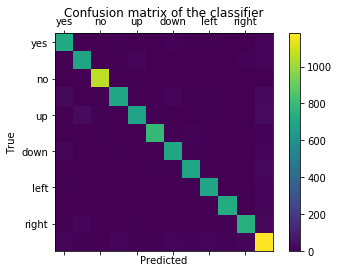

10113/10113 [==============================] - 3s 283us/step
Precision:  92.77 %


In [7]:
#find prediction with test data
preds = cnn.predict(x_test)
print(list(used))

#plot confusion matrix
plotConfusionMatrix(preds,y_test,list(used))
loss, precision = cnn.evaluate(x_test,y_test)
print ("Precision: ", round(precision*100,2),"%")

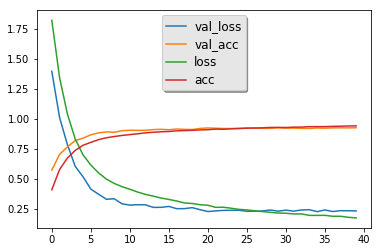

In [8]:
fig, ax = plt.subplots()
x = range(epoch)
for key in fitted.history:
    ax.plot(x,fitted.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

plt.show()
    

# Output of conv2D

In [ ]:
cnn_copy = Sequential()
cnn_copy.add(cnn.layers[0])
result = cnn_copy.predict(x_test)


In [ ]:
plt.figure()
plt.imshow(result[0,:,:,0])

# Save Model

In [9]:
dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)
name = 'cnn.bak'
cnn.save(dest_directory + name)

#bak = load_model(dest_directory + name)


In [ ]:
model = Model(input_shape=(x_train.shape[1], x_train.shape[2],1))
model.add(Conv2D(100, (4,4),  strides = (1,1), padding="valid"))
model.add(Conv2D(100, (4,2),  strides = (1,1), padding="valid"))
model.add(MaxPooling2D_drawer(pool_size=(3,3)))
model.add(Conv2D(128, (4,2),  strides = (1,1), padding="valid"))
model.add(Conv2D(128, (5,2),  strides = (1,1), padding="valid"))
model.add(MaxPooling2D_drawer(pool_size=(4,1)))
model.add(Flatten_drawer())
model.add(Dense_drawer(100))
model.add(Dense_drawer(y_train.shape[1]))

#save to pdf
save_model_to_file(model, "example.pdf")

# Looking for hyperparameters

In [16]:

def data():
    #load used data
    with open('variables/train_test_split.pkl', 'rb') as f: 
        x_train = pickle.load(f)
        y_train = pickle.load(f)
        x_test = pickle.load(f)
        y_test = pickle.load(f) 
    return x_train, y_train, x_test, y_test 

def create_model(x_train, y_train, x_test, y_test):
    activation = 'softplus'

    cnn = Sequential()

    cnn.add(Convolution2D(64, (6,4),  strides = (1,1), padding="valid", input_shape=(x_train.shape[1], x_train.shape[2],1)))
    cnn.add(Activation(activation))
    cnn.add(BatchNormalization())
    
    cnn.add(Dropout({{uniform(0, 0.9)}}))
    cnn.add(Convolution2D(128, (5,2),  strides = (1,1), padding="valid"))
    cnn.add(Activation(activation))
    cnn.add(BatchNormalization())
    
    
    cnn.add(MaxPooling2D(pool_size=(3,3)))
    
    cnn.add(Dropout({{uniform(0, 0.9)}}))
    cnn.add(Convolution2D(128, (3,2),  strides = (1,1), padding="valid"))
    cnn.add(Activation(activation))
    cnn.add(BatchNormalization())
    
    cnn.add(Dropout({{uniform(0, 0.9)}}))
    cnn.add(Convolution2D(256, (4,2),  strides = (1,1), padding="valid"))
    cnn.add(Activation(activation))
    cnn.add(BatchNormalization())
    
    cnn.add(Dropout({{uniform(0, 0.9)}}))
    cnn.add(MaxPooling2D(pool_size=(4,1)))


    cnn.add(Flatten())

    cnn.add(Dense(100, activation=activation))
    cnn.add(Dropout({{uniform(0.5, 1)}}))
    cnn.add(BatchNormalization())

    cnn.add(Dense(y_train.shape[1]))
    cnn.add(Activation({{choice(['softmax', 'sigmoid'])}}))
    cnn.compile(loss="categorical_crossentropy", optimizer="adamax", metrics=['accuracy'])
            
    cnn.fit(x_train, y_train,
              batch_size={{choice([128, 256])}},
              epochs=30,
              verbose=2,
              validation_data=(x_test, y_test))
    score, acc = cnn.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': cnn}

In [17]:
#from keras.layers.core import Dense, Dropout, Activation
trials = Trials()
best_run, best_model = optim.minimize(model=create_model, 
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=100,
                                      trials=trials,
                                      notebook_name='Processing')

>>> Imports:
#coding=utf-8

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import pickle
except:
    pass

try:
    from glob import glob
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    import random as rnd
except:
    pass

try:
    from keras.activations import softmax
except:
    pass

try:
    from keras.models import Sequential, load_model
except:
    pass

try:
    from keras.layers import Dense, Activation, Flatten, Dropout, Convolution2D, MaxPooling2D, AveragePooling2D, BatchNormalization
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    import sys
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform, conditional
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
ex

Epoch 24/30
 - 14s - loss: 0.2569 - acc: 0.9224 - val_loss: 0.2921 - val_acc: 0.9196
Epoch 25/30
 - 14s - loss: 0.2458 - acc: 0.9254 - val_loss: 0.2860 - val_acc: 0.9210
Epoch 26/30
 - 14s - loss: 0.2416 - acc: 0.9277 - val_loss: 0.2615 - val_acc: 0.9228
Epoch 27/30
 - 14s - loss: 0.2254 - acc: 0.9321 - val_loss: 0.3031 - val_acc: 0.9155
Epoch 28/30
 - 14s - loss: 0.2266 - acc: 0.9330 - val_loss: 0.3064 - val_acc: 0.9161
Epoch 29/30
 - 14s - loss: 0.2236 - acc: 0.9326 - val_loss: 0.2783 - val_acc: 0.9205
Epoch 30/30
 - 14s - loss: 0.2147 - acc: 0.9343 - val_loss: 0.2897 - val_acc: 0.9169
Test accuracy: 0.9168841873883775
Train on 29116 samples, validate on 7279 samples
Epoch 1/30
 - 16s - loss: 2.1759 - acc: 0.3069 - val_loss: 1.7336 - val_acc: 0.4958
Epoch 2/30
 - 14s - loss: 1.7275 - acc: 0.4263 - val_loss: 1.3985 - val_acc: 0.6456
Epoch 3/30
 - 14s - loss: 1.5076 - acc: 0.5063 - val_loss: 1.1944 - val_acc: 0.7011
Epoch 4/30
 - 14s - loss: 1.3411 - acc: 0.5619 - val_loss: 1.0594 - va

Epoch 28/30
 - 13s - loss: 0.1180 - acc: 0.9620 - val_loss: 0.2870 - val_acc: 0.9232
Epoch 29/30
 - 13s - loss: 0.1148 - acc: 0.9659 - val_loss: 0.3190 - val_acc: 0.9251
Epoch 30/30
 - 13s - loss: 0.1082 - acc: 0.9657 - val_loss: 0.2864 - val_acc: 0.9240
Test accuracy: 0.9240280258359121
Train on 29116 samples, validate on 7279 samples
Epoch 1/30
 - 15s - loss: 2.4636 - acc: 0.2603 - val_loss: 4.0167 - val_acc: 0.2169
Epoch 2/30
 - 13s - loss: 1.9498 - acc: 0.3543 - val_loss: 3.0942 - val_acc: 0.2738
Epoch 3/30
 - 13s - loss: 1.7639 - acc: 0.4125 - val_loss: 2.5252 - val_acc: 0.3539
Epoch 4/30
 - 13s - loss: 1.6536 - acc: 0.4487 - val_loss: 2.1206 - val_acc: 0.4104
Epoch 5/30
 - 13s - loss: 1.5564 - acc: 0.4850 - val_loss: 1.9607 - val_acc: 0.4635
Epoch 6/30
 - 13s - loss: 1.4766 - acc: 0.5183 - val_loss: 1.8375 - val_acc: 0.5001
Epoch 7/30
 - 13s - loss: 1.3729 - acc: 0.5523 - val_loss: 1.6486 - val_acc: 0.5504
Epoch 8/30
 - 13s - loss: 1.2906 - acc: 0.5775 - val_loss: 1.5179 - val_ac

 - 16s - loss: 2.3010 - acc: 0.2629 - val_loss: 12.6214 - val_acc: 0.1753
Epoch 2/30
 - 14s - loss: 1.9064 - acc: 0.3527 - val_loss: 10.0991 - val_acc: 0.2024
Epoch 3/30
 - 14s - loss: 1.7568 - acc: 0.4043 - val_loss: 8.4761 - val_acc: 0.2378
Epoch 4/30
 - 14s - loss: 1.6402 - acc: 0.4520 - val_loss: 6.3589 - val_acc: 0.2987
Epoch 5/30
 - 14s - loss: 1.5387 - acc: 0.4911 - val_loss: 5.5507 - val_acc: 0.3488
Epoch 6/30
 - 14s - loss: 1.4614 - acc: 0.5162 - val_loss: 4.6399 - val_acc: 0.4182
Epoch 7/30
 - 14s - loss: 1.3961 - acc: 0.5347 - val_loss: 4.1191 - val_acc: 0.4553
Epoch 8/30
 - 14s - loss: 1.3360 - acc: 0.5605 - val_loss: 3.6081 - val_acc: 0.4935
Epoch 9/30
 - 14s - loss: 1.2785 - acc: 0.5772 - val_loss: 3.5795 - val_acc: 0.5021
Epoch 10/30
 - 14s - loss: 1.2276 - acc: 0.5943 - val_loss: 3.5479 - val_acc: 0.5091
Epoch 11/30
 - 14s - loss: 1.1618 - acc: 0.6172 - val_loss: 2.7943 - val_acc: 0.5822
Epoch 12/30
 - 14s - loss: 1.1088 - acc: 0.6387 - val_loss: 2.9562 - val_acc: 0.583

Epoch 5/30
 - 13s - loss: 1.2562 - acc: 0.5942 - val_loss: 1.9747 - val_acc: 0.6159
Epoch 6/30
 - 13s - loss: 1.1556 - acc: 0.6285 - val_loss: 1.8391 - val_acc: 0.6436
Epoch 7/30
 - 13s - loss: 1.0835 - acc: 0.6493 - val_loss: 1.5396 - val_acc: 0.6881
Epoch 8/30
 - 13s - loss: 1.0044 - acc: 0.6747 - val_loss: 1.4356 - val_acc: 0.7130
Epoch 9/30
 - 13s - loss: 0.9379 - acc: 0.6966 - val_loss: 1.3733 - val_acc: 0.7303
Epoch 10/30
 - 13s - loss: 0.8893 - acc: 0.7138 - val_loss: 1.1612 - val_acc: 0.7588
Epoch 11/30
 - 13s - loss: 0.8423 - acc: 0.7299 - val_loss: 1.2189 - val_acc: 0.7616
Epoch 12/30
 - 13s - loss: 0.8027 - acc: 0.7420 - val_loss: 1.0496 - val_acc: 0.7785
Epoch 13/30
 - 13s - loss: 0.7793 - acc: 0.7492 - val_loss: 0.9421 - val_acc: 0.7934
Epoch 14/30
 - 13s - loss: 0.7396 - acc: 0.7608 - val_loss: 0.9142 - val_acc: 0.8100
Epoch 15/30
 - 13s - loss: 0.7074 - acc: 0.7723 - val_loss: 0.9722 - val_acc: 0.8126
Epoch 16/30
 - 13s - loss: 0.6878 - acc: 0.7801 - val_loss: 0.7824 - v

Epoch 9/30
 - 14s - loss: 0.9030 - acc: 0.7091 - val_loss: 1.0226 - val_acc: 0.7636
Epoch 10/30
 - 14s - loss: 0.8587 - acc: 0.7245 - val_loss: 0.9141 - val_acc: 0.7898
Epoch 11/30
 - 14s - loss: 0.8213 - acc: 0.7355 - val_loss: 1.0063 - val_acc: 0.7829
Epoch 12/30
 - 14s - loss: 0.7801 - acc: 0.7487 - val_loss: 0.8856 - val_acc: 0.8013
Epoch 13/30
 - 14s - loss: 0.7516 - acc: 0.7588 - val_loss: 0.8812 - val_acc: 0.8090
Epoch 14/30
 - 14s - loss: 0.7199 - acc: 0.7686 - val_loss: 0.8739 - val_acc: 0.8174
Epoch 15/30
 - 14s - loss: 0.7003 - acc: 0.7775 - val_loss: 0.7874 - val_acc: 0.8306
Epoch 16/30
 - 14s - loss: 0.6659 - acc: 0.7876 - val_loss: 0.8431 - val_acc: 0.8294
Epoch 17/30
 - 14s - loss: 0.6537 - acc: 0.7924 - val_loss: 0.7781 - val_acc: 0.8387
Epoch 18/30
 - 14s - loss: 0.6367 - acc: 0.7965 - val_loss: 0.7204 - val_acc: 0.8453
Epoch 19/30
 - 14s - loss: 0.6149 - acc: 0.8033 - val_loss: 0.7030 - val_acc: 0.8508
Epoch 20/30
 - 14s - loss: 0.6011 - acc: 0.8071 - val_loss: 0.6962

Epoch 13/30
 - 13s - loss: 1.3907 - acc: 0.5178 - val_loss: 1.2786 - val_acc: 0.7272
Epoch 14/30
 - 13s - loss: 1.3545 - acc: 0.5296 - val_loss: 1.0926 - val_acc: 0.7570
Epoch 15/30
 - 13s - loss: 1.3176 - acc: 0.5391 - val_loss: 1.0993 - val_acc: 0.7702
Epoch 16/30
 - 13s - loss: 1.2939 - acc: 0.5448 - val_loss: 1.0366 - val_acc: 0.7847
Epoch 17/30
 - 13s - loss: 1.2590 - acc: 0.5571 - val_loss: 0.9772 - val_acc: 0.7983
Epoch 18/30
 - 13s - loss: 1.2460 - acc: 0.5604 - val_loss: 0.9869 - val_acc: 0.8033
Epoch 19/30
 - 13s - loss: 1.2182 - acc: 0.5694 - val_loss: 1.0630 - val_acc: 0.7983
Epoch 20/30
 - 13s - loss: 1.2055 - acc: 0.5728 - val_loss: 1.0178 - val_acc: 0.8078
Epoch 21/30
 - 13s - loss: 1.1862 - acc: 0.5808 - val_loss: 0.9498 - val_acc: 0.8206
Epoch 22/30
 - 13s - loss: 1.1635 - acc: 0.5862 - val_loss: 0.8704 - val_acc: 0.8266
Epoch 23/30
 - 13s - loss: 1.1568 - acc: 0.5881 - val_loss: 0.9392 - val_acc: 0.8221
Epoch 24/30
 - 13s - loss: 1.1291 - acc: 0.5986 - val_loss: 0.849

Epoch 17/30
 - 13s - loss: 1.6687 - acc: 0.3949 - val_loss: 1.5907 - val_acc: 0.4867
Epoch 18/30
 - 13s - loss: 1.6398 - acc: 0.4052 - val_loss: 1.5477 - val_acc: 0.5252
Epoch 19/30
 - 13s - loss: 1.6213 - acc: 0.4062 - val_loss: 1.5110 - val_acc: 0.5414
Epoch 20/30
 - 13s - loss: 1.6091 - acc: 0.4137 - val_loss: 1.4742 - val_acc: 0.5497
Epoch 21/30
 - 13s - loss: 1.5910 - acc: 0.4183 - val_loss: 1.5398 - val_acc: 0.5225
Epoch 22/30
 - 13s - loss: 1.5720 - acc: 0.4263 - val_loss: 1.4679 - val_acc: 0.5686
Epoch 23/30
 - 13s - loss: 1.5559 - acc: 0.4305 - val_loss: 1.4998 - val_acc: 0.5181
Epoch 24/30
 - 13s - loss: 1.5406 - acc: 0.4363 - val_loss: 1.4476 - val_acc: 0.5710
Epoch 25/30
 - 13s - loss: 1.5354 - acc: 0.4411 - val_loss: 1.4101 - val_acc: 0.5803
Epoch 26/30
 - 13s - loss: 1.5104 - acc: 0.4470 - val_loss: 1.4354 - val_acc: 0.5847
Epoch 27/30
 - 13s - loss: 1.5054 - acc: 0.4482 - val_loss: 1.4365 - val_acc: 0.5550
Epoch 28/30
 - 13s - loss: 1.4953 - acc: 0.4560 - val_loss: 1.421

Epoch 21/30
 - 13s - loss: 0.3678 - acc: 0.8895 - val_loss: 0.3103 - val_acc: 0.9078
Epoch 22/30
 - 13s - loss: 0.3695 - acc: 0.8885 - val_loss: 0.3078 - val_acc: 0.9055
Epoch 23/30
 - 13s - loss: 0.3523 - acc: 0.8962 - val_loss: 0.2812 - val_acc: 0.9195
Epoch 24/30
 - 13s - loss: 0.3374 - acc: 0.8981 - val_loss: 0.2749 - val_acc: 0.9181
Epoch 25/30
 - 13s - loss: 0.3342 - acc: 0.8989 - val_loss: 0.2908 - val_acc: 0.9125
Epoch 26/30
 - 13s - loss: 0.3236 - acc: 0.9031 - val_loss: 0.2635 - val_acc: 0.9162
Epoch 27/30
 - 13s - loss: 0.3144 - acc: 0.9034 - val_loss: 0.2850 - val_acc: 0.9170
Epoch 28/30
 - 13s - loss: 0.3106 - acc: 0.9056 - val_loss: 0.2801 - val_acc: 0.9172
Epoch 29/30
 - 13s - loss: 0.3002 - acc: 0.9099 - val_loss: 0.2670 - val_acc: 0.9198
Epoch 30/30
 - 13s - loss: 0.2939 - acc: 0.9117 - val_loss: 0.2861 - val_acc: 0.9185
Test accuracy: 0.9185327655061423
Train on 29116 samples, validate on 7279 samples
Epoch 1/30
 - 17s - loss: 2.1474 - acc: 0.3552 - val_loss: 1.7801 -

Epoch 25/30
 - 13s - loss: 2.1841 - acc: 0.2347 - val_loss: 1.9792 - val_acc: 0.3601
Epoch 26/30
 - 13s - loss: 2.1771 - acc: 0.2326 - val_loss: 1.9476 - val_acc: 0.3639
Epoch 27/30
 - 13s - loss: 2.1825 - acc: 0.2361 - val_loss: 1.9225 - val_acc: 0.4120
Epoch 28/30
 - 13s - loss: 2.1750 - acc: 0.2355 - val_loss: 1.9325 - val_acc: 0.3231
Epoch 29/30
 - 13s - loss: 2.1739 - acc: 0.2345 - val_loss: 1.9666 - val_acc: 0.3411
Epoch 30/30
 - 13s - loss: 2.1658 - acc: 0.2347 - val_loss: 1.9740 - val_acc: 0.3408
Test accuracy: 0.3408435224680181
Train on 29116 samples, validate on 7279 samples
Epoch 1/30
 - 17s - loss: 2.0326 - acc: 0.4126 - val_loss: 1.7002 - val_acc: 0.5501
Epoch 2/30
 - 13s - loss: 1.6264 - acc: 0.5405 - val_loss: 1.2986 - val_acc: 0.6509
Epoch 3/30
 - 13s - loss: 1.2091 - acc: 0.6500 - val_loss: 0.9851 - val_acc: 0.7170
Epoch 4/30
 - 13s - loss: 0.8650 - acc: 0.7506 - val_loss: 0.7312 - val_acc: 0.7884
Epoch 5/30
 - 13s - loss: 0.6731 - acc: 0.8059 - val_loss: 0.6969 - val

Epoch 29/30
 - 13s - loss: 0.1604 - acc: 0.9525 - val_loss: 0.3092 - val_acc: 0.9180
Epoch 30/30
 - 13s - loss: 0.1509 - acc: 0.9557 - val_loss: 0.3302 - val_acc: 0.9147
Test accuracy: 0.9146860832695712
Train on 29116 samples, validate on 7279 samples
Epoch 1/30
 - 18s - loss: 2.0389 - acc: 0.3984 - val_loss: 1.7643 - val_acc: 0.5086
Epoch 2/30
 - 13s - loss: 1.6767 - acc: 0.5212 - val_loss: 1.4583 - val_acc: 0.5903
Epoch 3/30
 - 13s - loss: 1.2943 - acc: 0.6231 - val_loss: 0.9926 - val_acc: 0.7272
Epoch 4/30
 - 13s - loss: 0.9364 - acc: 0.7259 - val_loss: 0.8654 - val_acc: 0.7516
Epoch 5/30
 - 13s - loss: 0.7349 - acc: 0.7841 - val_loss: 0.6849 - val_acc: 0.8229
Epoch 6/30
 - 13s - loss: 0.6084 - acc: 0.8204 - val_loss: 0.6191 - val_acc: 0.8343
Epoch 7/30
 - 13s - loss: 0.5403 - acc: 0.8404 - val_loss: 0.6692 - val_acc: 0.8527
Epoch 8/30
 - 13s - loss: 0.4778 - acc: 0.8603 - val_loss: 0.5483 - val_acc: 0.8715
Epoch 9/30
 - 13s - loss: 0.4330 - acc: 0.8738 - val_loss: 0.5210 - val_acc

Epoch 2/30
 - 15s - loss: 1.8882 - acc: 0.4015 - val_loss: 1.5321 - val_acc: 0.5796
Epoch 3/30
 - 15s - loss: 1.5912 - acc: 0.4766 - val_loss: 1.2415 - val_acc: 0.6575
Epoch 4/30
 - 15s - loss: 1.3479 - acc: 0.5623 - val_loss: 1.0431 - val_acc: 0.6980
Epoch 5/30
 - 15s - loss: 1.1774 - acc: 0.6237 - val_loss: 0.8276 - val_acc: 0.7795
Epoch 6/30
 - 15s - loss: 1.0681 - acc: 0.6596 - val_loss: 0.6666 - val_acc: 0.8339
Epoch 7/30
 - 15s - loss: 0.9785 - acc: 0.6941 - val_loss: 0.6653 - val_acc: 0.8324
Epoch 8/30
 - 15s - loss: 0.9133 - acc: 0.7143 - val_loss: 0.5807 - val_acc: 0.8450
Epoch 9/30
 - 15s - loss: 0.8469 - acc: 0.7378 - val_loss: 0.5717 - val_acc: 0.8606
Epoch 10/30
 - 15s - loss: 0.8034 - acc: 0.7516 - val_loss: 0.4787 - val_acc: 0.8806
Epoch 11/30
 - 15s - loss: 0.7694 - acc: 0.7622 - val_loss: 0.4415 - val_acc: 0.8867
Epoch 12/30
 - 15s - loss: 0.7397 - acc: 0.7707 - val_loss: 0.4245 - val_acc: 0.8919
Epoch 13/30
 - 15s - loss: 0.7029 - acc: 0.7853 - val_loss: 0.4229 - val_

Epoch 6/30
 - 13s - loss: 1.3877 - acc: 0.5386 - val_loss: 1.2184 - val_acc: 0.7129
Epoch 7/30
 - 13s - loss: 1.2755 - acc: 0.5794 - val_loss: 0.9678 - val_acc: 0.7616
Epoch 8/30
 - 13s - loss: 1.1742 - acc: 0.6207 - val_loss: 0.8917 - val_acc: 0.7820
Epoch 9/30
 - 13s - loss: 1.0989 - acc: 0.6422 - val_loss: 0.8065 - val_acc: 0.8097
Epoch 10/30
 - 13s - loss: 1.0270 - acc: 0.6671 - val_loss: 0.7118 - val_acc: 0.8334
Epoch 11/30
 - 13s - loss: 0.9795 - acc: 0.6863 - val_loss: 0.7095 - val_acc: 0.8368
Epoch 12/30
 - 13s - loss: 0.9216 - acc: 0.7047 - val_loss: 0.6374 - val_acc: 0.8479
Epoch 13/30
 - 13s - loss: 0.8803 - acc: 0.7210 - val_loss: 0.6271 - val_acc: 0.8553
Epoch 14/30
 - 13s - loss: 0.8431 - acc: 0.7345 - val_loss: 0.5444 - val_acc: 0.8715
Epoch 15/30
 - 13s - loss: 0.8048 - acc: 0.7468 - val_loss: 0.5555 - val_acc: 0.8744
Epoch 16/30
 - 13s - loss: 0.7741 - acc: 0.7542 - val_loss: 0.4529 - val_acc: 0.8808
Epoch 17/30
 - 13s - loss: 0.7438 - acc: 0.7647 - val_loss: 0.4851 - 

Epoch 10/30
 - 13s - loss: 0.4515 - acc: 0.8652 - val_loss: 0.4975 - val_acc: 0.8835
Epoch 11/30
 - 13s - loss: 0.4145 - acc: 0.8769 - val_loss: 0.5345 - val_acc: 0.8838
Epoch 12/30
 - 13s - loss: 0.3867 - acc: 0.8825 - val_loss: 0.5822 - val_acc: 0.8814
Epoch 13/30
 - 13s - loss: 0.3639 - acc: 0.8919 - val_loss: 0.4874 - val_acc: 0.8970
Epoch 14/30
 - 13s - loss: 0.3374 - acc: 0.8982 - val_loss: 0.4569 - val_acc: 0.8982
Epoch 15/30
 - 13s - loss: 0.3258 - acc: 0.8998 - val_loss: 0.5027 - val_acc: 0.8950
Epoch 16/30
 - 13s - loss: 0.3067 - acc: 0.9085 - val_loss: 0.4534 - val_acc: 0.9040
Epoch 17/30
 - 13s - loss: 0.2927 - acc: 0.9129 - val_loss: 0.4218 - val_acc: 0.9045
Epoch 18/30
 - 13s - loss: 0.2799 - acc: 0.9125 - val_loss: 0.4601 - val_acc: 0.9015
Epoch 19/30
 - 13s - loss: 0.2620 - acc: 0.9192 - val_loss: 0.4827 - val_acc: 0.9086
Epoch 20/30
 - 13s - loss: 0.2538 - acc: 0.9232 - val_loss: 0.4575 - val_acc: 0.9114
Epoch 21/30
 - 13s - loss: 0.2405 - acc: 0.9276 - val_loss: 0.401

Epoch 14/30
 - 13s - loss: 0.5072 - acc: 0.8465 - val_loss: 0.6010 - val_acc: 0.8710
Epoch 15/30
 - 13s - loss: 0.4761 - acc: 0.8564 - val_loss: 0.4921 - val_acc: 0.8884
Epoch 16/30
 - 13s - loss: 0.4603 - acc: 0.8607 - val_loss: 0.5427 - val_acc: 0.8861
Epoch 17/30
 - 13s - loss: 0.4346 - acc: 0.8701 - val_loss: 0.4453 - val_acc: 0.8911
Epoch 18/30
 - 13s - loss: 0.4070 - acc: 0.8753 - val_loss: 0.4459 - val_acc: 0.8966
Epoch 19/30
 - 13s - loss: 0.4029 - acc: 0.8781 - val_loss: 0.4176 - val_acc: 0.8996
Epoch 20/30
 - 13s - loss: 0.3836 - acc: 0.8832 - val_loss: 0.4539 - val_acc: 0.8993
Epoch 21/30
 - 13s - loss: 0.3669 - acc: 0.8891 - val_loss: 0.4482 - val_acc: 0.9051
Epoch 22/30
 - 13s - loss: 0.3573 - acc: 0.8916 - val_loss: 0.4617 - val_acc: 0.9029
Epoch 23/30
 - 13s - loss: 0.3472 - acc: 0.8936 - val_loss: 0.3799 - val_acc: 0.9128
Epoch 24/30
 - 13s - loss: 0.3277 - acc: 0.9003 - val_loss: 0.3719 - val_acc: 0.9102
Epoch 25/30
 - 13s - loss: 0.3215 - acc: 0.9025 - val_loss: 0.381

Epoch 18/30
 - 13s - loss: 0.3181 - acc: 0.9085 - val_loss: 0.3430 - val_acc: 0.9052
Epoch 19/30
 - 13s - loss: 0.3069 - acc: 0.9130 - val_loss: 0.3375 - val_acc: 0.9113
Epoch 20/30
 - 13s - loss: 0.2899 - acc: 0.9165 - val_loss: 0.3120 - val_acc: 0.9121
Epoch 21/30
 - 13s - loss: 0.2826 - acc: 0.9181 - val_loss: 0.3152 - val_acc: 0.9174
Epoch 22/30
 - 13s - loss: 0.2696 - acc: 0.9246 - val_loss: 0.3605 - val_acc: 0.9009
Epoch 23/30
 - 13s - loss: 0.2632 - acc: 0.9244 - val_loss: 0.3085 - val_acc: 0.9148
Epoch 24/30
 - 13s - loss: 0.2545 - acc: 0.9262 - val_loss: 0.3080 - val_acc: 0.9158
Epoch 25/30
 - 13s - loss: 0.2394 - acc: 0.9311 - val_loss: 0.3003 - val_acc: 0.9203
Epoch 26/30
 - 13s - loss: 0.2323 - acc: 0.9331 - val_loss: 0.2847 - val_acc: 0.9205
Epoch 27/30
 - 13s - loss: 0.2297 - acc: 0.9327 - val_loss: 0.2992 - val_acc: 0.9170
Epoch 28/30
 - 13s - loss: 0.2189 - acc: 0.9365 - val_loss: 0.3082 - val_acc: 0.9144
Epoch 29/30
 - 13s - loss: 0.2119 - acc: 0.9382 - val_loss: 0.281

Epoch 22/30
 - 13s - loss: 1.4779 - acc: 0.4892 - val_loss: 1.8088 - val_acc: 0.6534
Epoch 23/30
 - 13s - loss: 1.4587 - acc: 0.4944 - val_loss: 1.7350 - val_acc: 0.6762
Epoch 24/30
 - 13s - loss: 1.4398 - acc: 0.5023 - val_loss: 1.6649 - val_acc: 0.6924
Epoch 25/30
 - 13s - loss: 1.4115 - acc: 0.5082 - val_loss: 1.5877 - val_acc: 0.7063
Epoch 26/30
 - 13s - loss: 1.3957 - acc: 0.5136 - val_loss: 1.6093 - val_acc: 0.7037
Epoch 27/30
 - 13s - loss: 1.3830 - acc: 0.5235 - val_loss: 1.4943 - val_acc: 0.7243
Epoch 28/30
 - 13s - loss: 1.3663 - acc: 0.5266 - val_loss: 1.4134 - val_acc: 0.7328
Epoch 29/30
 - 13s - loss: 1.3589 - acc: 0.5245 - val_loss: 1.4696 - val_acc: 0.7336
Epoch 30/30
 - 13s - loss: 1.3362 - acc: 0.5335 - val_loss: 1.3682 - val_acc: 0.7425
Test accuracy: 0.7425470531993981
Train on 29116 samples, validate on 7279 samples
Epoch 1/30
 - 20s - loss: 2.3641 - acc: 0.2749 - val_loss: 8.8742 - val_acc: 0.2199
Epoch 2/30
 - 13s - loss: 1.9239 - acc: 0.3563 - val_loss: 6.8917 - 

Epoch 26/30
 - 15s - loss: 0.3178 - acc: 0.9043 - val_loss: 0.4117 - val_acc: 0.9081
Epoch 27/30
 - 15s - loss: 0.3063 - acc: 0.9073 - val_loss: 0.3683 - val_acc: 0.9144
Epoch 28/30
 - 15s - loss: 0.2983 - acc: 0.9096 - val_loss: 0.3763 - val_acc: 0.9119
Epoch 29/30
 - 15s - loss: 0.2967 - acc: 0.9099 - val_loss: 0.3816 - val_acc: 0.9151
Epoch 30/30
 - 15s - loss: 0.2909 - acc: 0.9115 - val_loss: 0.4133 - val_acc: 0.9147
Test accuracy: 0.9146860832777598
Train on 29116 samples, validate on 7279 samples
Epoch 1/30
 - 21s - loss: 2.1618 - acc: 0.3247 - val_loss: 6.8384 - val_acc: 0.2750
Epoch 2/30
 - 13s - loss: 1.6603 - acc: 0.4590 - val_loss: 3.8033 - val_acc: 0.4454
Epoch 3/30
 - 13s - loss: 1.4442 - acc: 0.5329 - val_loss: 3.3058 - val_acc: 0.5223
Epoch 4/30
 - 13s - loss: 1.2831 - acc: 0.5904 - val_loss: 2.6433 - val_acc: 0.5846
Epoch 5/30
 - 13s - loss: 1.1518 - acc: 0.6314 - val_loss: 2.3498 - val_acc: 0.6249
Epoch 6/30
 - 13s - loss: 1.0593 - acc: 0.6614 - val_loss: 1.8940 - val_

Epoch 30/30
 - 13s - loss: 0.2804 - acc: 0.9157 - val_loss: 0.3881 - val_acc: 0.9106
Test accuracy: 0.9105646380079138
Train on 29116 samples, validate on 7279 samples
Epoch 1/30
 - 22s - loss: 2.1710 - acc: 0.3255 - val_loss: 1.9140 - val_acc: 0.3771
Epoch 2/30
 - 15s - loss: 1.7612 - acc: 0.4368 - val_loss: 1.5271 - val_acc: 0.5357
Epoch 3/30
 - 15s - loss: 1.4087 - acc: 0.5519 - val_loss: 1.1366 - val_acc: 0.6707
Epoch 4/30
 - 15s - loss: 1.1205 - acc: 0.6440 - val_loss: 0.9118 - val_acc: 0.7460
Epoch 5/30
 - 15s - loss: 0.9424 - acc: 0.7004 - val_loss: 0.7794 - val_acc: 0.7938
Epoch 6/30
 - 15s - loss: 0.8345 - acc: 0.7408 - val_loss: 0.7747 - val_acc: 0.8056
Epoch 7/30
 - 15s - loss: 0.7529 - acc: 0.7691 - val_loss: 0.6801 - val_acc: 0.8255
Epoch 8/30
 - 15s - loss: 0.6927 - acc: 0.7903 - val_loss: 0.6530 - val_acc: 0.8426
Epoch 9/30
 - 15s - loss: 0.6461 - acc: 0.8044 - val_loss: 0.6034 - val_acc: 0.8522
Epoch 10/30
 - 15s - loss: 0.6129 - acc: 0.8161 - val_loss: 0.5941 - val_acc

Epoch 3/30
 - 13s - loss: 1.8890 - acc: 0.3690 - val_loss: 1.7916 - val_acc: 0.4141
Epoch 4/30
 - 13s - loss: 1.7595 - acc: 0.4061 - val_loss: 1.6496 - val_acc: 0.4620
Epoch 5/30
 - 13s - loss: 1.6397 - acc: 0.4593 - val_loss: 1.4988 - val_acc: 0.5444
Epoch 6/30
 - 13s - loss: 1.5154 - acc: 0.5072 - val_loss: 1.3525 - val_acc: 0.6030
Epoch 7/30
 - 14s - loss: 1.3872 - acc: 0.5499 - val_loss: 1.2458 - val_acc: 0.6501
Epoch 8/30
 - 13s - loss: 1.2733 - acc: 0.5850 - val_loss: 1.1336 - val_acc: 0.6833
Epoch 9/30
 - 13s - loss: 1.1825 - acc: 0.6153 - val_loss: 1.0898 - val_acc: 0.7015
Epoch 10/30
 - 13s - loss: 1.1058 - acc: 0.6407 - val_loss: 1.0528 - val_acc: 0.7129
Epoch 11/30
 - 13s - loss: 1.0367 - acc: 0.6627 - val_loss: 1.0243 - val_acc: 0.7285
Epoch 12/30
 - 13s - loss: 0.9893 - acc: 0.6806 - val_loss: 0.9200 - val_acc: 0.7612
Epoch 13/30
 - 13s - loss: 0.9314 - acc: 0.7001 - val_loss: 0.8980 - val_acc: 0.7729
Epoch 14/30
 - 13s - loss: 0.8858 - acc: 0.7191 - val_loss: 0.8608 - val

Epoch 7/30
 - 13s - loss: 0.5251 - acc: 0.8467 - val_loss: 0.5022 - val_acc: 0.8611
Epoch 8/30
 - 13s - loss: 0.4658 - acc: 0.8633 - val_loss: 0.4893 - val_acc: 0.8692
Epoch 9/30
 - 13s - loss: 0.4219 - acc: 0.8782 - val_loss: 0.3937 - val_acc: 0.8922
Epoch 10/30
 - 13s - loss: 0.3833 - acc: 0.8896 - val_loss: 0.4008 - val_acc: 0.8890
Epoch 11/30
 - 13s - loss: 0.3587 - acc: 0.8947 - val_loss: 0.4988 - val_acc: 0.8825
Epoch 12/30
 - 13s - loss: 0.3317 - acc: 0.9052 - val_loss: 0.3397 - val_acc: 0.9041
Epoch 13/30
 - 13s - loss: 0.3095 - acc: 0.9114 - val_loss: 0.3975 - val_acc: 0.8983
Epoch 14/30
 - 13s - loss: 0.2921 - acc: 0.9147 - val_loss: 0.3798 - val_acc: 0.9051
Epoch 15/30
 - 13s - loss: 0.2716 - acc: 0.9209 - val_loss: 0.3627 - val_acc: 0.9081
Epoch 16/30
 - 13s - loss: 0.2582 - acc: 0.9256 - val_loss: 0.4109 - val_acc: 0.8900
Epoch 17/30
 - 13s - loss: 0.2469 - acc: 0.9270 - val_loss: 0.3494 - val_acc: 0.9107
Epoch 18/30
 - 13s - loss: 0.2346 - acc: 0.9322 - val_loss: 0.3189 -

Epoch 11/30
 - 15s - loss: 0.6275 - acc: 0.8107 - val_loss: 0.6827 - val_acc: 0.8622
Epoch 12/30
 - 15s - loss: 0.5993 - acc: 0.8201 - val_loss: 0.6082 - val_acc: 0.8692
Epoch 13/30
 - 15s - loss: 0.5718 - acc: 0.8266 - val_loss: 0.6467 - val_acc: 0.8751
Epoch 14/30
 - 15s - loss: 0.5451 - acc: 0.8358 - val_loss: 0.6221 - val_acc: 0.8795
Epoch 15/30
 - 15s - loss: 0.5189 - acc: 0.8450 - val_loss: 0.5902 - val_acc: 0.8861
Epoch 16/30
 - 15s - loss: 0.5066 - acc: 0.8475 - val_loss: 0.5889 - val_acc: 0.8900
Epoch 17/30
 - 15s - loss: 0.4843 - acc: 0.8529 - val_loss: 0.5022 - val_acc: 0.8934
Epoch 18/30
 - 15s - loss: 0.4646 - acc: 0.8603 - val_loss: 0.5180 - val_acc: 0.8971
Epoch 19/30
 - 15s - loss: 0.4505 - acc: 0.8655 - val_loss: 0.5353 - val_acc: 0.8959
Epoch 20/30
 - 15s - loss: 0.4432 - acc: 0.8660 - val_loss: 0.4645 - val_acc: 0.9025
Epoch 21/30
 - 15s - loss: 0.4329 - acc: 0.8691 - val_loss: 0.4921 - val_acc: 0.9022
Epoch 22/30
 - 15s - loss: 0.4150 - acc: 0.8740 - val_loss: 0.506

Epoch 15/30
 - 13s - loss: 0.3662 - acc: 0.8894 - val_loss: 0.4322 - val_acc: 0.8911
Epoch 16/30
 - 13s - loss: 0.3511 - acc: 0.8926 - val_loss: 0.4097 - val_acc: 0.8916
Epoch 17/30
 - 13s - loss: 0.3338 - acc: 0.8975 - val_loss: 0.3876 - val_acc: 0.8986
Epoch 18/30
 - 13s - loss: 0.3194 - acc: 0.9015 - val_loss: 0.3569 - val_acc: 0.9088
Epoch 19/30
 - 13s - loss: 0.3058 - acc: 0.9067 - val_loss: 0.3478 - val_acc: 0.9071
Epoch 20/30
 - 13s - loss: 0.2944 - acc: 0.9106 - val_loss: 0.3305 - val_acc: 0.9129
Epoch 21/30
 - 13s - loss: 0.2793 - acc: 0.9131 - val_loss: 0.3293 - val_acc: 0.9148
Epoch 22/30
 - 13s - loss: 0.2746 - acc: 0.9153 - val_loss: 0.3277 - val_acc: 0.9144
Epoch 23/30
 - 13s - loss: 0.2596 - acc: 0.9207 - val_loss: 0.3165 - val_acc: 0.9185
Epoch 24/30
 - 13s - loss: 0.2551 - acc: 0.9223 - val_loss: 0.3176 - val_acc: 0.9172
Epoch 25/30
 - 13s - loss: 0.2432 - acc: 0.9256 - val_loss: 0.3115 - val_acc: 0.9181
Epoch 26/30
 - 14s - loss: 0.2344 - acc: 0.9273 - val_loss: 0.317

Epoch 19/30
 - 14s - loss: 0.1551 - acc: 0.9527 - val_loss: 0.2941 - val_acc: 0.9132
Epoch 20/30
 - 14s - loss: 0.1467 - acc: 0.9550 - val_loss: 0.2935 - val_acc: 0.9198
Epoch 21/30
 - 14s - loss: 0.1386 - acc: 0.9581 - val_loss: 0.3094 - val_acc: 0.9132
Epoch 22/30
 - 14s - loss: 0.1241 - acc: 0.9616 - val_loss: 0.3111 - val_acc: 0.9137
Epoch 23/30
 - 13s - loss: 0.1205 - acc: 0.9622 - val_loss: 0.3015 - val_acc: 0.9203
Epoch 24/30
 - 14s - loss: 0.1137 - acc: 0.9648 - val_loss: 0.3025 - val_acc: 0.9188
Epoch 25/30
 - 14s - loss: 0.1018 - acc: 0.9686 - val_loss: 0.3061 - val_acc: 0.9163
Epoch 26/30
 - 14s - loss: 0.0956 - acc: 0.9706 - val_loss: 0.3335 - val_acc: 0.9207
Epoch 27/30
 - 14s - loss: 0.0895 - acc: 0.9724 - val_loss: 0.3165 - val_acc: 0.9180
Epoch 28/30
 - 14s - loss: 0.0863 - acc: 0.9743 - val_loss: 0.3398 - val_acc: 0.9137
Epoch 29/30
 - 14s - loss: 0.0777 - acc: 0.9767 - val_loss: 0.3337 - val_acc: 0.9199
Epoch 30/30
 - 14s - loss: 0.0773 - acc: 0.9760 - val_loss: 0.327

Epoch 23/30
 - 14s - loss: 0.2684 - acc: 0.9175 - val_loss: 0.3147 - val_acc: 0.9203
Epoch 24/30
 - 14s - loss: 0.2585 - acc: 0.9204 - val_loss: 0.3313 - val_acc: 0.9163
Epoch 25/30
 - 14s - loss: 0.2549 - acc: 0.9213 - val_loss: 0.3267 - val_acc: 0.9134
Epoch 26/30
 - 14s - loss: 0.2460 - acc: 0.9236 - val_loss: 0.3304 - val_acc: 0.9174
Epoch 27/30
 - 14s - loss: 0.2323 - acc: 0.9292 - val_loss: 0.3295 - val_acc: 0.9163
Epoch 28/30
 - 14s - loss: 0.2228 - acc: 0.9308 - val_loss: 0.3130 - val_acc: 0.9200
Epoch 29/30
 - 14s - loss: 0.2171 - acc: 0.9343 - val_loss: 0.2957 - val_acc: 0.9211
Epoch 30/30
 - 14s - loss: 0.2125 - acc: 0.9362 - val_loss: 0.2808 - val_acc: 0.9242
Test accuracy: 0.9241654073443611
Train on 29116 samples, validate on 7279 samples
Epoch 1/30
 - 24s - loss: 2.2067 - acc: 0.3110 - val_loss: 2.4146 - val_acc: 0.4102
Epoch 2/30
 - 14s - loss: 1.7185 - acc: 0.4351 - val_loss: 1.6753 - val_acc: 0.5417
Epoch 3/30
 - 14s - loss: 1.5164 - acc: 0.5058 - val_loss: 1.4200 - v

Epoch 27/30
 - 14s - loss: 0.3217 - acc: 0.9021 - val_loss: 0.4571 - val_acc: 0.9008
Epoch 28/30
 - 14s - loss: 0.3138 - acc: 0.9044 - val_loss: 0.4299 - val_acc: 0.9051
Epoch 29/30
 - 14s - loss: 0.3039 - acc: 0.9050 - val_loss: 0.4281 - val_acc: 0.9011
Epoch 30/30
 - 14s - loss: 0.2997 - acc: 0.9099 - val_loss: 0.3924 - val_acc: 0.9081
Test accuracy: 0.908091770864021
Train on 29116 samples, validate on 7279 samples
Epoch 1/30
 - 24s - loss: 2.1988 - acc: 0.3142 - val_loss: 1.9279 - val_acc: 0.3599
Epoch 2/30
 - 13s - loss: 1.8627 - acc: 0.4142 - val_loss: 1.7109 - val_acc: 0.4630
Epoch 3/30
 - 13s - loss: 1.6482 - acc: 0.4766 - val_loss: 1.4340 - val_acc: 0.5912
Epoch 4/30
 - 13s - loss: 1.4010 - acc: 0.5578 - val_loss: 1.1483 - val_acc: 0.6870
Epoch 5/30
 - 13s - loss: 1.1705 - acc: 0.6369 - val_loss: 1.0586 - val_acc: 0.6980
Epoch 6/30
 - 13s - loss: 0.9918 - acc: 0.6867 - val_loss: 0.9159 - val_acc: 0.7314
Epoch 7/30
 - 13s - loss: 0.8766 - acc: 0.7267 - val_loss: 0.8511 - val_ac

Test accuracy: 0.9086412968978169
Train on 29116 samples, validate on 7279 samples
Epoch 1/30
 - 26s - loss: 2.2451 - acc: 0.3055 - val_loss: 1.8354 - val_acc: 0.4633
Epoch 2/30
 - 15s - loss: 1.8771 - acc: 0.4043 - val_loss: 1.4940 - val_acc: 0.6012
Epoch 3/30
 - 15s - loss: 1.5823 - acc: 0.4830 - val_loss: 1.2350 - val_acc: 0.6586
Epoch 4/30
 - 15s - loss: 1.3482 - acc: 0.5651 - val_loss: 1.0634 - val_acc: 0.7453
Epoch 5/30
 - 15s - loss: 1.1801 - acc: 0.6204 - val_loss: 0.9294 - val_acc: 0.7652
Epoch 6/30
 - 15s - loss: 1.0745 - acc: 0.6581 - val_loss: 0.7258 - val_acc: 0.8133
Epoch 7/30
 - 15s - loss: 0.9842 - acc: 0.6868 - val_loss: 0.6640 - val_acc: 0.8342
Epoch 8/30
 - 15s - loss: 0.9221 - acc: 0.7065 - val_loss: 0.6738 - val_acc: 0.8398
Epoch 9/30
 - 15s - loss: 0.8797 - acc: 0.7238 - val_loss: 0.6145 - val_acc: 0.8526
Epoch 10/30
 - 15s - loss: 0.8336 - acc: 0.7391 - val_loss: 0.7027 - val_acc: 0.8443
Epoch 11/30
 - 15s - loss: 0.7922 - acc: 0.7518 - val_loss: 0.6331 - val_acc

Epoch 4/30
 - 14s - loss: 1.0889 - acc: 0.6683 - val_loss: 0.8693 - val_acc: 0.7667
Epoch 5/30
 - 14s - loss: 0.8689 - acc: 0.7384 - val_loss: 0.7299 - val_acc: 0.7968
Epoch 6/30
 - 14s - loss: 0.7320 - acc: 0.7775 - val_loss: 0.6316 - val_acc: 0.8373
Epoch 7/30
 - 14s - loss: 0.6393 - acc: 0.8091 - val_loss: 0.5797 - val_acc: 0.8530
Epoch 8/30
 - 14s - loss: 0.5648 - acc: 0.8307 - val_loss: 0.6168 - val_acc: 0.8533
Epoch 9/30
 - 14s - loss: 0.5164 - acc: 0.8452 - val_loss: 0.5680 - val_acc: 0.8735
Epoch 10/30
 - 14s - loss: 0.4672 - acc: 0.8611 - val_loss: 0.5040 - val_acc: 0.8850
Epoch 11/30
 - 14s - loss: 0.4339 - acc: 0.8720 - val_loss: 0.4910 - val_acc: 0.8869
Epoch 12/30
 - 14s - loss: 0.4080 - acc: 0.8787 - val_loss: 0.3832 - val_acc: 0.8989
Epoch 13/30
 - 14s - loss: 0.3869 - acc: 0.8846 - val_loss: 0.3948 - val_acc: 0.9029
Epoch 14/30
 - 14s - loss: 0.3564 - acc: 0.8961 - val_loss: 0.3499 - val_acc: 0.9059
Epoch 15/30
 - 14s - loss: 0.3357 - acc: 0.9000 - val_loss: 0.3731 - va

Epoch 8/30
 - 14s - loss: 2.4919 - acc: 0.1857 - val_loss: 2.3379 - val_acc: 0.1747
Epoch 9/30
 - 14s - loss: 2.4863 - acc: 0.1857 - val_loss: 2.3312 - val_acc: 0.1747
Epoch 10/30
 - 14s - loss: 2.4771 - acc: 0.1881 - val_loss: 2.2558 - val_acc: 0.1750
Epoch 11/30
 - 14s - loss: 2.4682 - acc: 0.1873 - val_loss: 2.2342 - val_acc: 0.1753
Epoch 12/30
 - 14s - loss: 2.4621 - acc: 0.1884 - val_loss: 2.2219 - val_acc: 0.1761
Epoch 13/30
 - 14s - loss: 2.4571 - acc: 0.1890 - val_loss: 2.2325 - val_acc: 0.1768
Epoch 14/30
 - 14s - loss: 2.4513 - acc: 0.1896 - val_loss: 2.2099 - val_acc: 0.1763
Epoch 15/30
 - 14s - loss: 2.4434 - acc: 0.1902 - val_loss: 2.2302 - val_acc: 0.1774
Epoch 16/30
 - 14s - loss: 2.4384 - acc: 0.1915 - val_loss: 2.1567 - val_acc: 0.1774
Epoch 17/30
 - 14s - loss: 2.4321 - acc: 0.1923 - val_loss: 2.1244 - val_acc: 0.1886
Epoch 18/30
 - 14s - loss: 2.4236 - acc: 0.1923 - val_loss: 2.1121 - val_acc: 0.1823
Epoch 19/30
 - 14s - loss: 2.4190 - acc: 0.1932 - val_loss: 2.0693 

Epoch 12/30
 - 16s - loss: 0.3264 - acc: 0.9028 - val_loss: 0.4511 - val_acc: 0.8953
Epoch 13/30
 - 16s - loss: 0.3062 - acc: 0.9093 - val_loss: 0.4706 - val_acc: 0.9001
Epoch 14/30
 - 16s - loss: 0.2878 - acc: 0.9144 - val_loss: 0.4068 - val_acc: 0.9078
Epoch 15/30
 - 16s - loss: 0.2749 - acc: 0.9175 - val_loss: 0.4516 - val_acc: 0.8971
Epoch 16/30
 - 16s - loss: 0.2542 - acc: 0.9229 - val_loss: 0.4772 - val_acc: 0.9100
Epoch 17/30
 - 16s - loss: 0.2447 - acc: 0.9280 - val_loss: 0.4123 - val_acc: 0.9100
Epoch 18/30
 - 16s - loss: 0.2348 - acc: 0.9291 - val_loss: 0.4060 - val_acc: 0.9107
Epoch 19/30
 - 16s - loss: 0.2280 - acc: 0.9317 - val_loss: 0.4622 - val_acc: 0.9140
Epoch 20/30
 - 16s - loss: 0.2129 - acc: 0.9355 - val_loss: 0.4039 - val_acc: 0.9124
Epoch 21/30
 - 16s - loss: 0.2052 - acc: 0.9394 - val_loss: 0.4904 - val_acc: 0.9069
Epoch 22/30
 - 16s - loss: 0.1954 - acc: 0.9411 - val_loss: 0.4715 - val_acc: 0.9085
Epoch 23/30
 - 16s - loss: 0.1918 - acc: 0.9422 - val_loss: 0.382

Epoch 16/30
 - 14s - loss: 0.5314 - acc: 0.8398 - val_loss: 0.6148 - val_acc: 0.8691
Epoch 17/30
 - 14s - loss: 0.5082 - acc: 0.8469 - val_loss: 0.4838 - val_acc: 0.8922
Epoch 18/30
 - 14s - loss: 0.4992 - acc: 0.8503 - val_loss: 0.4443 - val_acc: 0.8923
Epoch 19/30
 - 14s - loss: 0.4766 - acc: 0.8559 - val_loss: 0.4802 - val_acc: 0.8924
Epoch 20/30
 - 14s - loss: 0.4548 - acc: 0.8618 - val_loss: 0.4746 - val_acc: 0.8959
Epoch 21/30
 - 14s - loss: 0.4395 - acc: 0.8672 - val_loss: 0.4015 - val_acc: 0.9026
Epoch 22/30
 - 14s - loss: 0.4287 - acc: 0.8713 - val_loss: 0.3993 - val_acc: 0.9051
Epoch 23/30
 - 14s - loss: 0.4143 - acc: 0.8770 - val_loss: 0.3836 - val_acc: 0.9066
Epoch 24/30
 - 14s - loss: 0.4168 - acc: 0.8766 - val_loss: 0.4459 - val_acc: 0.8990
Epoch 25/30
 - 14s - loss: 0.3937 - acc: 0.8813 - val_loss: 0.4340 - val_acc: 0.9018
Epoch 26/30
 - 14s - loss: 0.3839 - acc: 0.8847 - val_loss: 0.4605 - val_acc: 0.9080
Epoch 27/30
 - 14s - loss: 0.3753 - acc: 0.8865 - val_loss: 0.458

Epoch 20/30
 - 14s - loss: 0.9720 - acc: 0.6715 - val_loss: 0.6288 - val_acc: 0.8728
Epoch 21/30
 - 14s - loss: 0.9618 - acc: 0.6740 - val_loss: 0.5972 - val_acc: 0.8776
Epoch 22/30
 - 14s - loss: 0.9563 - acc: 0.6727 - val_loss: 0.5926 - val_acc: 0.8661
Epoch 23/30
 - 14s - loss: 0.9395 - acc: 0.6845 - val_loss: 0.6123 - val_acc: 0.8699
Epoch 24/30
 - 14s - loss: 0.9179 - acc: 0.6863 - val_loss: 0.5385 - val_acc: 0.8842
Epoch 25/30
 - 14s - loss: 0.9168 - acc: 0.6865 - val_loss: 0.5793 - val_acc: 0.8792
Epoch 26/30
 - 14s - loss: 0.9025 - acc: 0.6906 - val_loss: 0.5153 - val_acc: 0.8850
Epoch 27/30
 - 14s - loss: 0.8890 - acc: 0.6966 - val_loss: 0.5246 - val_acc: 0.8897
Epoch 28/30
 - 14s - loss: 0.8726 - acc: 0.7025 - val_loss: 0.4778 - val_acc: 0.8956
Epoch 29/30
 - 14s - loss: 0.8626 - acc: 0.7046 - val_loss: 0.4602 - val_acc: 0.8946
Epoch 30/30
 - 14s - loss: 0.8422 - acc: 0.7086 - val_loss: 0.4839 - val_acc: 0.8915
Test accuracy: 0.8914686083416966
Train on 29116 samples, validat

Epoch 24/30
 - 16s - loss: 0.3068 - acc: 0.9048 - val_loss: 0.3045 - val_acc: 0.9172
Epoch 25/30
 - 16s - loss: 0.3076 - acc: 0.9058 - val_loss: 0.3147 - val_acc: 0.9200
Epoch 26/30
 - 16s - loss: 0.2961 - acc: 0.9084 - val_loss: 0.3307 - val_acc: 0.9178
Epoch 27/30
 - 16s - loss: 0.2896 - acc: 0.9115 - val_loss: 0.3043 - val_acc: 0.9185
Epoch 28/30
 - 16s - loss: 0.2849 - acc: 0.9120 - val_loss: 0.3118 - val_acc: 0.9152
Epoch 29/30
 - 16s - loss: 0.2782 - acc: 0.9159 - val_loss: 0.3008 - val_acc: 0.9191
Epoch 30/30
 - 16s - loss: 0.2768 - acc: 0.9153 - val_loss: 0.3220 - val_acc: 0.9183
Test accuracy: 0.9182580024810557
Train on 29116 samples, validate on 7279 samples
Epoch 1/30
 - 28s - loss: 2.1127 - acc: 0.3657 - val_loss: 1.7639 - val_acc: 0.5167
Epoch 2/30
 - 14s - loss: 1.7500 - acc: 0.4863 - val_loss: 1.4819 - val_acc: 0.6563
Epoch 3/30
 - 14s - loss: 1.3908 - acc: 0.5873 - val_loss: 1.0533 - val_acc: 0.7213
Epoch 4/30
 - 14s - loss: 1.0671 - acc: 0.6810 - val_loss: 0.8394 - va

In [18]:
dest_directory = 'model_backup/'
'''
best_model = load_model(dest_directory + 'best_model.bak')

with open(dest_directory+'best_run.pkl', 'rb') as f:  
    best_run = pickle.load(f)    
'''
print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.summary()




now = datetime.datetime.now()
dest_directory_temp =dest_directory + 'bestModel('+now.strftime("%m-%d %H.%M")+")"
if not os.path.exists(dest_directory_temp):
      os.makedirs(dest_directory_temp)
best_model.save(dest_directory_temp + '/best_model.bak')

with open(dest_directory_temp + '/best_run.pkl', 'wb') as f:  
    pickle.dump(best_run, f)



Evalutation of best performing model:
7279/7279 [==============================] - 3s 469us/step
[0.28674337853665927, 0.9266382744964424]
Best performing model chosen hyper-parameters:
{'Activation': 1, 'Activation_1': 1, 'Convolution2D': 1, 'Convolution2D_1': 1, 'Convolution2D_2': 0, 'Dense': 1, 'Dropout': 0.388989907673126, 'Dropout_1': 0.3788702615621363, 'Dropout_2': 0.08773276436904592, 'Dropout_3': 0.28462239911427234, 'Dropout_4': 0.6136421896108873, 'Dropout_5': 0.8718561068587479, 'Dropout_6': 0.6857696002796559, 'Dropout_7': 0.6601182742334564, 'batch_size': 1}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_337 (Conv2D)          (None, 94, 10, 64)        1600      
_________________________________________________________________
activation_419 (Activation)  (None, 94, 10, 64)        0         
_________________________________________________________________
batch_normalization_421 (

TypeError: can't pickle _thread.RLock objects

In [20]:
trials.best_trial

{'book_time': datetime.datetime(2018, 6, 22, 1, 25, 42, 929000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'Activation': [82],
   'Activation_1': [82],
   'Convolution2D': [82],
   'Convolution2D_1': [82],
   'Convolution2D_2': [82],
   'Dense': [82],
   'Dropout': [82],
   'Dropout_1': [82],
   'Dropout_2': [82],
   'Dropout_3': [82],
   'Dropout_4': [82],
   'Dropout_5': [82],
   'Dropout_6': [82],
   'Dropout_7': [82],
   'batch_size': [82]},
  'tid': 82,
  'vals': {'Activation': [1],
   'Activation_1': [1],
   'Convolution2D': [1],
   'Convolution2D_1': [1],
   'Convolution2D_2': [0],
   'Dense': [1],
   'Dropout': [0.388989907673126],
   'Dropout_1': [0.3788702615621363],
   'Dropout_2': [0.08773276436904592],
   'Dropout_3': [0.28462239911427234],
   'Dropout_4': [0.6136421896108873],
   'Dropout_5': [0.8718561068587479],
   'Dropout_6': [0.6857696002796559],
   'Dropout_7': [0.6601182742334564],
   'batch_size': [1]},
  'workdir': No